# 1. Data Import and Checks

In [8]:
# Load the dataset
import pandas as pd

df = pd.read_csv(r"C:\Users\Ellen\Desktop\Air\mer_imputed_merged_data.xlsx - Sheet1.csv") 


In [10]:
# Display column names
print(df.columns)


Index(['datetime', 'direct_radiation (W/m²)', 'PM25_MER', 'PM10_MER',
       'SO2_MER', 'O3_MER', 'NO2_MER', 'CO_MER', 'RH_MER', 'TMP_MER',
       'WDR_MER', 'WSP_MER', 'is_festival', 'is_weekend', 'AirQualityIndex'],
      dtype='object')


In [12]:
# Adjust column list to match the dataset
pollutants_weather = [
    'O3_MER', 'PM25_MER', 'PM10_MER', 'TMP_MER', 'RH_MER', 
    'WSP_MER', 'AirQualityIndex', 'datetime'
]

# Focus on relevant columns
df_focus = df[pollutants_weather]

# Check for missing values
print(df_focus.isnull().sum())

# Handle missing values (drop rows with missing data)
df_focus = df_focus.dropna()

# Convert 'datetime' to DateTime format for temporal analysis
df_focus['datetime'] = pd.to_datetime(df_focus['datetime'])


O3_MER             0
PM25_MER           0
PM10_MER           0
TMP_MER            0
RH_MER             0
WSP_MER            0
AirQualityIndex    0
datetime           0
dtype: int64


# 2. Descriptive Statistics and Summary
Summarize key numerical columns, focusing on pollutants and weather conditions.

In [18]:
summary_stats = df.describe()
print(summary_stats)

       direct_radiation (W/m²)      PM25_MER      PM10_MER       SO2_MER  \
count             26788.000000  26788.000000  26788.000000  26788.000000   
mean                198.299313     21.938476     39.138806      3.653750   
std                 285.059521     12.670387     20.382502      5.767726   
min                   0.000000      1.000000      2.000000      0.000000   
25%                   0.000000     13.000000     24.000000      1.000000   
50%                   2.000000     20.000000     36.000000      2.000000   
75%                 383.000000     29.000000     51.000000      4.000000   
max                1008.000000    186.000000    411.000000    251.000000   

             O3_MER       NO2_MER        CO_MER        RH_MER       TMP_MER  \
count  26788.000000  26788.000000  26788.000000  26788.000000  26788.000000   
mean      25.629505     30.601047      0.505975     49.909788     18.849627   
std       26.409113     13.298383      0.382489     19.936643      4.285339   

**Visualise Distrubutions:** Use histograms to explore pollutant distributions.

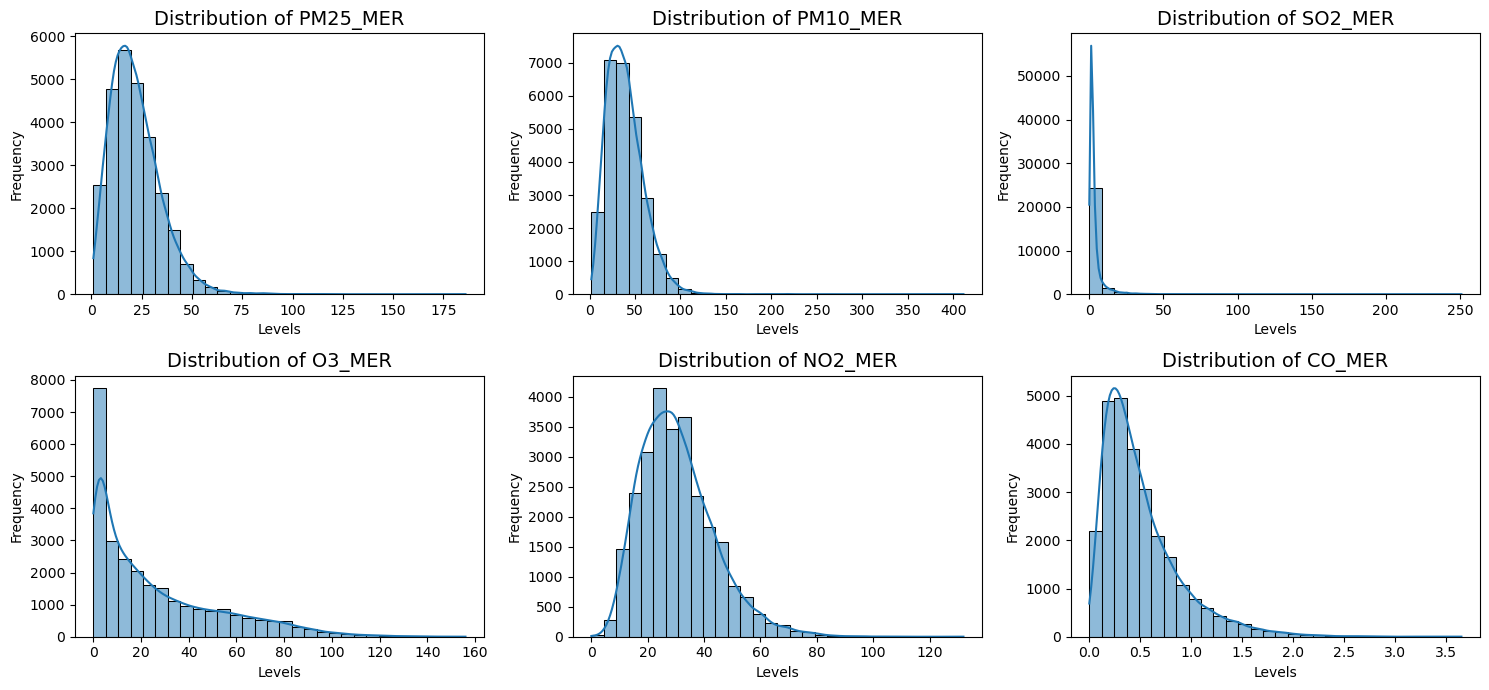

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of pollutants
pollutants = ['PM25_MER', 'PM10_MER', 'SO2_MER', 'O3_MER', 'NO2_MER', 'CO_MER']

# Set up the grid layout: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 7))  # Adjust figsize for appropriate scaling

# Iterate through pollutants and create histograms
for i, pollutant in enumerate(pollutants):
    row = i // 3  # Determine the row index
    col = i % 3   # Determine the column index
    sns.histplot(df[pollutant], kde=True, bins=30, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {pollutant}', fontsize=14)
    axes[row, col].set_xlabel('Levels')
    axes[row, col].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Summary of histogram findings** Findings of pollutant distributions that calculate key statistics and identify any notable features such as skewness, peaks, or spread.

In [24]:
import pandas as pd

# List of pollutants
pollutants = ['PM25_MER', 'PM10_MER', 'SO2_MER', 'O3_MER', 'NO2_MER', 'CO_MER']

# Initialize a dictionary to store summary results
summary_results = {}

# Loop through each pollutant and calculate summary statistics
for pollutant in pollutants:
    data = df[pollutant].dropna()  # Drop missing values for accurate stats
    summary_results[pollutant] = {
        'Mean': data.mean(),
        'Median': data.median(),
        'Standard Deviation': data.std(),
        'Min': data.min(),
        'Max': data.max(),
        'Skewness': data.skew()
    }

# Convert the summary results to a DataFrame for a cleaner display
summary_df = pd.DataFrame(summary_results).T  # Transpose for better readability

# Display the summary
print("Summary of Pollutant Distributions:")
print(summary_df)

Summary of Pollutant Distributions:
               Mean  Median  Standard Deviation  Min     Max  Skewness
PM25_MER  21.938476    20.0           12.670387  1.0  186.00  1.345145
PM10_MER  39.138806    36.0           20.382502  2.0  411.00  1.371658
SO2_MER    3.653750     2.0            5.767726  0.0  251.00  9.201196
O3_MER    25.629505    16.0           26.409113  0.0  156.00  1.239636
NO2_MER   30.601047    29.0           13.298383  0.0  132.00  0.901484
CO_MER     0.505975     0.4            0.382489  0.0    3.65  1.684903


**Summary of Pollutant Distributions**

**General Observations:**

1. The pollutants vary significantly in their mean and variability, indicating diverse sources and behaviors.
2. The skewness values suggest that most pollutants exhibit positive skew, indicating the presence of occasional high values (spikes).

**Notable Observations:**

1. **SO2_MER** stands out with extremely high skewness (9.20), indicating rare but significant spikes in sulfur dioxide levels. These could be linked to industrial emissions or specific events.
2. **PM10_MER and PM25_MER** show wide ranges, reflecting potential high-pollution episodes likely driven by traffic, construction, or natural events like dust storms.
3. **CO_MER** has relatively low values but shows occasional spikes, possibly from localized combustion activities.

**Implications:**

1. The high skewness and wide ranges in several pollutants **(SO2, PM10, PM2.5)** highlight the importance of outlier analysis to investigate pollution events.
2. The relatively symmetric distribution of **NO2** suggests more consistent sources, such as vehicular traffic or background emissions. Understanding these patterns is crucial for identifying pollution hotspots and mitigating sources.

# 3. Outlier Analysis

**Detect Outliers (IQR Method):** Create a reusable function for detecting outliers.

In [28]:
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

**Analyze Outliers for Each Pollutant:** Store and summarize the outliers for later analysis.

In [31]:
outliers_summary = {}
for pollutant in pollutants:
    outliers = detect_outliers(df, pollutant)
    outliers_summary[pollutant] = len(outliers)
    print(f'{pollutant}: {len(outliers)} outliers detected')

PM25_MER: 493 outliers detected
PM10_MER: 397 outliers detected
SO2_MER: 2347 outliers detected
O3_MER: 506 outliers detected
NO2_MER: 554 outliers detected
CO_MER: 1212 outliers detected


**Visualize Outliers:** Use box plots to identify outlier ranges.

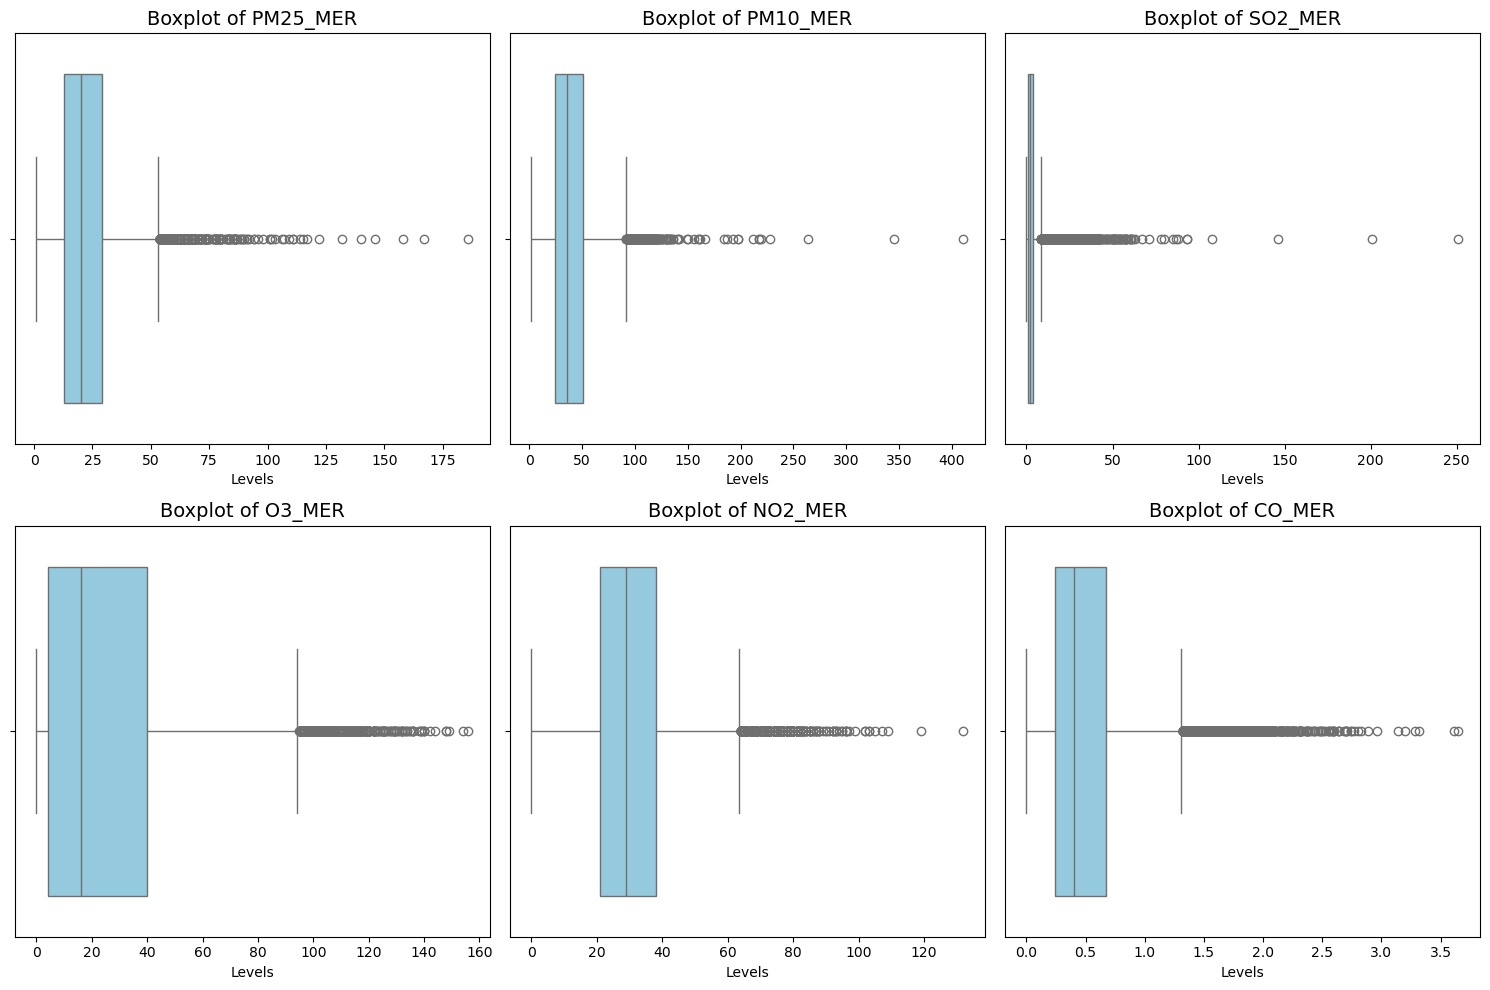

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of pollutants
pollutants = ['PM25_MER', 'PM10_MER', 'SO2_MER', 'O3_MER', 'NO2_MER', 'CO_MER']

# Set up the grid layout: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize for better scaling

# Loop through pollutants and create boxplots
for i, pollutant in enumerate(pollutants):
    row = i // 3  # Determine the row index
    col = i % 3   # Determine the column index
    sns.boxplot(x=df[pollutant], ax=axes[row, col], color='skyblue')
    axes[row, col].set_title(f'Boxplot of {pollutant}', fontsize=14)
    axes[row, col].set_xlabel('Levels')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [36]:
import pandas as pd

# List of pollutants
pollutants = ['PM25_MER', 'PM10_MER', 'SO2_MER', 'O3_MER', 'NO2_MER', 'CO_MER']

# Initialize a dictionary to store summary results
boxplot_summary = {}

# Loop through each pollutant to calculate key statistics
for pollutant in pollutants:
    data = df[pollutant].dropna()  # Drop missing values
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    # Store findings
    boxplot_summary[pollutant] = {
        'Q1 (25th Percentile)': Q1,
        'Median (50th Percentile)': data.median(),
        'Q3 (75th Percentile)': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Number of Outliers': len(outliers)
    }

# Convert the summary to a DataFrame for easier display
boxplot_summary_df = pd.DataFrame(boxplot_summary).T

# Display the summary
print("Summary of Boxplot Findings:")
print(boxplot_summary_df)

Summary of Boxplot Findings:
          Q1 (25th Percentile)  Median (50th Percentile)  \
PM25_MER                 13.00                      20.0   
PM10_MER                 24.00                      36.0   
SO2_MER                   1.00                       2.0   
O3_MER                    4.00                      16.0   
NO2_MER                  21.00                      29.0   
CO_MER                    0.24                       0.4   

          Q3 (75th Percentile)    IQR  Lower Bound  Upper Bound  \
PM25_MER                 29.00  16.00      -11.000       53.000   
PM10_MER                 51.00  27.00      -16.500       91.500   
SO2_MER                   4.00   3.00       -3.500        8.500   
O3_MER                   40.00  36.00      -50.000       94.000   
NO2_MER                  38.00  17.00       -4.500       63.500   
CO_MER                    0.67   0.43       -0.405        1.315   

          Number of Outliers  
PM25_MER               493.0  
PM10_MER          

**Summary of Pollutant Distributions**

**General Observations:**

1. The pollutants vary significantly in their mean and variability, indicating diverse sources and behaviors.
2. The skewness values suggest that most pollutants exhibit positive skew, indicating the presence of occasional high values (spikes).

**Notable Observations:**

1. **SO2_MER** stands out with extremely high skewness (9.20), indicating rare but significant spikes in sulfur dioxide levels. These could be linked to industrial emissions or specific events.
2. **PM10_MER and PM25_MER** show wide ranges, reflecting potential high-pollution episodes likely driven by traffic, construction, or natural events like dust storms.
3. **CO_MER** has relatively low values but shows occasional spikes, possibly from localized combustion activities.
4. **03_MER** exhibits moderate skewness (1.24) and a relatively high standard deviation (26.41), indicating significant variability in ozone levels. The spikes may be driven by photochemical reactions involving vehicle emissions and sunlight, especially during sunny periods.

**Implications:**

1. The high skewness and wide ranges in several pollutants **(SO2, PM10, PM2.5)** highlight the importance of outlier analysis to investigate pollution events.
2. The relatively symmetric distribution of **NO2** suggests more consistent sources, such as vehicular traffic or background emissions. Understanding these patterns is crucial for identifying pollution hotspots and mitigating sources.
3. **O3** variability emphasizes the need to analyze temporal patterns, particularly during the day when ozone production is typically highest. Understanding ozone trends can aid in identifying periods of elevated photochemical smog and guiding mitigation efforts for vulnerable populations.

In [43]:
# Understand central tendencies and variability for pollutants.
print(df_focus[['O3_MER', 'PM25_MER', 'PM10_MER']].describe())


             O3_MER      PM25_MER      PM10_MER
count  26788.000000  26788.000000  26788.000000
mean      25.629505     21.938476     39.138806
std       26.409113     12.670387     20.382502
min        0.000000      1.000000      2.000000
25%        4.000000     13.000000     24.000000
50%       16.000000     20.000000     36.000000
75%       40.000000     29.000000     51.000000
max      156.000000    186.000000    411.000000


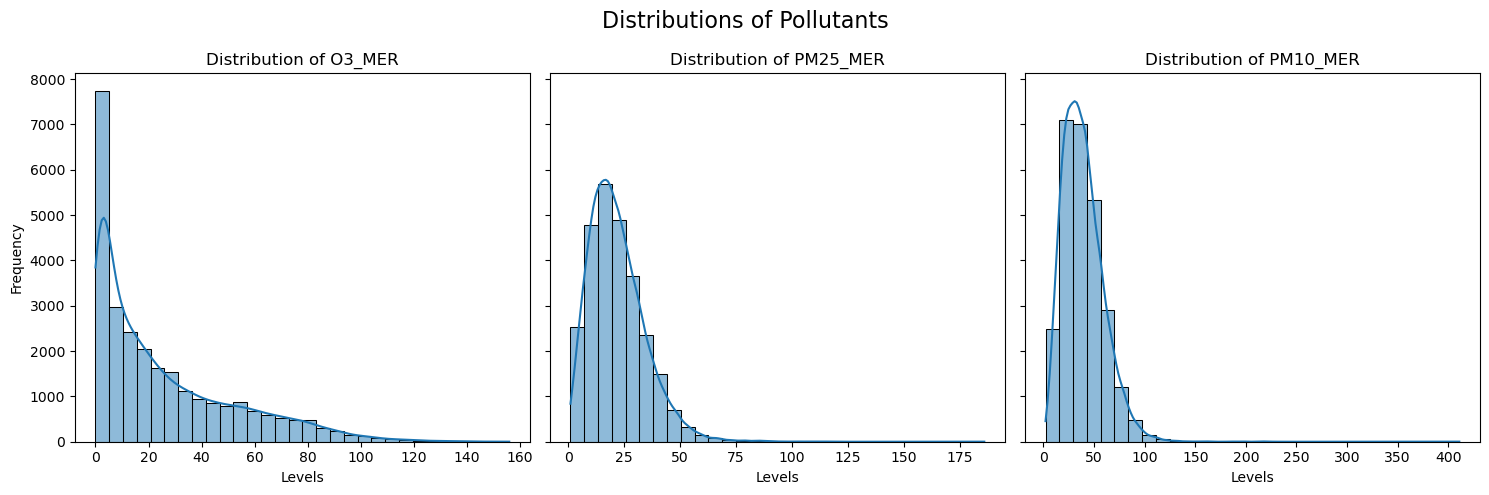

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

pollutants = ['O3_MER', 'PM25_MER', 'PM10_MER']

# Create a grid of histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Distributions of Pollutants', fontsize=16)

for ax, pollutant in zip(axes, pollutants):
    sns.histplot(df_focus[pollutant], kde=True, bins=30, ax=ax)
    ax.set_title(f'Distribution of {pollutant}')
    ax.set_xlabel('Levels')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


**Key Insights:**

1. Ozone **(O3)** shows significant variability, likely influenced by seasonal and daily patterns like sunlight and temperature.
2. **PM2.5 and PM10** exhibit high maximum values (186 and 411 µg/m³, respectively), suggesting extreme pollution events, which are critical to health concerns.
3. **PM10** shows the greatest variability, indicating frequent fluctuations, possibly due to larger particulate sources like dust and construction.

# Outlier Analysis

In [50]:
# Detect outliers for each pollutant using IQR
for pollutant in pollutants:
    Q1 = df_focus[pollutant].quantile(0.25)
    Q3 = df_focus[pollutant].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR

    # Add an outlier flag for each pollutant
    df_focus[f'{pollutant}_Outlier'] = df_focus[pollutant] > upper_bound


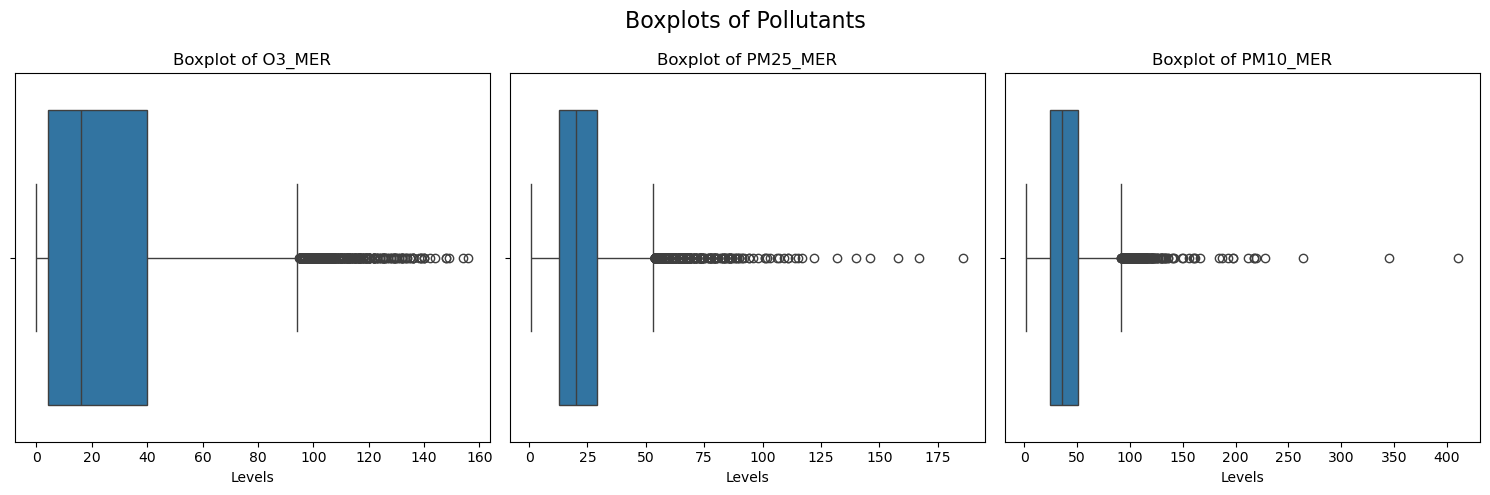

Summary for O3_MER:
  Median: 16.0
  IQR: 36.0
  Lower Whisker: -50.0
  Upper Whisker: 94.0
  Number of Outliers: 506
  Outlier Range: (94.75, 156.0)
--------------------------------------------------
Summary for PM25_MER:
  Median: 20.0
  IQR: 16.0
  Lower Whisker: -11.0
  Upper Whisker: 53.0
  Number of Outliers: 493
  Outlier Range: (54.0, 186.0)
--------------------------------------------------
Summary for PM10_MER:
  Median: 36.0
  IQR: 27.0
  Lower Whisker: -16.5
  Upper Whisker: 91.5
  Number of Outliers: 397
  Outlier Range: (91.70833333, 411.0)
--------------------------------------------------


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create boxplots for pollutants
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Boxplots of Pollutants', fontsize=16)

summary = {}

for ax, pollutant in zip(axes, pollutants):
    sns.boxplot(data=df_focus, x=pollutant, ax=ax)
    ax.set_title(f'Boxplot of {pollutant}')
    ax.set_xlabel('Levels')

    # Calculate boxplot statistics
    Q1 = df_focus[pollutant].quantile(0.25)
    Q3 = df_focus[pollutant].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    outliers = df_focus[(df_focus[pollutant] < lower_whisker) | (df_focus[pollutant] > upper_whisker)][pollutant]

    # Add findings to summary
    summary[pollutant] = {
        'Median': df_focus[pollutant].median(),
        'IQR': IQR,
        'Lower Whisker': lower_whisker,
        'Upper Whisker': upper_whisker,
        'Number of Outliers': len(outliers),
        'Outlier Range': (outliers.min(), outliers.max()) if not outliers.empty else "No outliers",
    }

plt.tight_layout()
plt.show()

# Print summary of findings
for pollutant, stats in summary.items():
    print(f"Summary for {pollutant}:")
    print(f"  Median: {stats['Median']}")
    print(f"  IQR: {stats['IQR']}")
    print(f"  Lower Whisker: {stats['Lower Whisker']}")
    print(f"  Upper Whisker: {stats['Upper Whisker']}")
    print(f"  Number of Outliers: {stats['Number of Outliers']}")
    print(f"  Outlier Range: {stats['Outlier Range']}")
    print("-" * 50)


**General Observations**

**Outliers:** All three pollutants show a substantial number of high outliers, particularly O3 and PM10, suggesting spikes in pollution levels that could pose health risks.

**Insights**
1. Ozone **(O3)** has a significant number of high-level outliers, likely driven by environmental factors like temperature and sunlight, which increase ozone formation.
2. **PM2.5** shows frequent but smaller outliers compared to PM10, likely due to pollution from combustion processes (e.g., vehicle emissions, burning).
3. **PM10** has the largest variability and extreme values, likely driven by sources like construction dust, windblown soil, and industrial activity.

**Variability:**
**PM10** is the most variable pollutant, with the widest IQR and largest outlier range, indicating frequent high-pollution events.
**PM2.5** is the least variable, suggesting more consistent levels.

**Health Risks:** 
High levels of PM2.5 and PM10 are known to cause respiratory and cardiovascular issues, while O3 is a key contributor to smog and can exacerbate asthma and lung conditions.

# Detect Multivariate Outliers

Use **Isolation Forest and Local Outlier Factor** to detect outliers.

In [58]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_focus['Iso_Outlier'] = iso_forest.fit_predict(df_focus[pollutants])
df_focus['Iso_Outlier'] = df_focus['Iso_Outlier'].map({1: 'Inlier', -1: 'Outlier'})

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_outliers = lof.fit_predict(df_focus[pollutants])
df_focus['LOF_Outlier'] = ['Inlier' if x == 1 else 'Outlier' for x in lof_outliers]


In [60]:
# Count the Outliers: Summarize the number of outliers detected by Isolation Forest and Local Outlier Factor for each pollutant.
iso_outliers_count = df_focus['Iso_Outlier'].value_counts()
lof_outliers_count = df_focus['LOF_Outlier'].value_counts()

print("Isolation Forest Outliers:")
print(iso_outliers_count)

print("\nLocal Outlier Factor Outliers:")
print(lof_outliers_count)


Isolation Forest Outliers:
Iso_Outlier
Inlier     25448
Outlier     1340
Name: count, dtype: int64

Local Outlier Factor Outliers:
LOF_Outlier
Inlier     25448
Outlier     1340
Name: count, dtype: int64


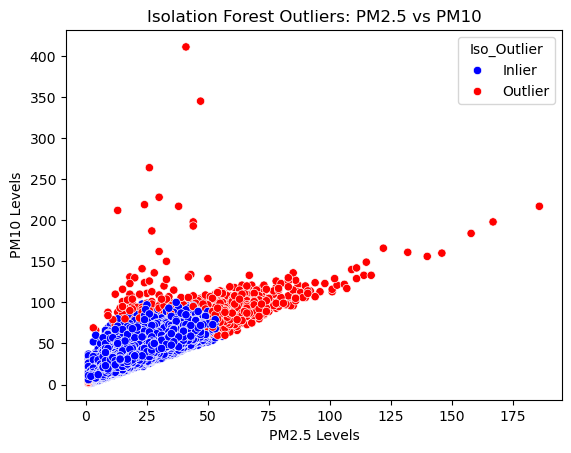

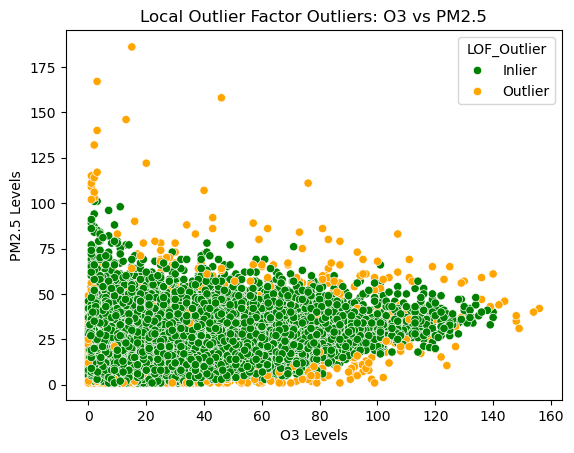

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot for Isolation Forest
sns.scatterplot(data=df_focus, x='PM25_MER', y='PM10_MER', hue='Iso_Outlier', palette={'Inlier': 'blue', 'Outlier': 'red'})
plt.title('Isolation Forest Outliers: PM2.5 vs PM10')
plt.xlabel('PM2.5 Levels')
plt.ylabel('PM10 Levels')
plt.show()

# Scatterplot for Local Outlier Factor
sns.scatterplot(data=df_focus, x='O3_MER', y='PM25_MER', hue='LOF_Outlier', palette={'Inlier': 'green', 'Outlier': 'orange'})
plt.title('Local Outlier Factor Outliers: O3 vs PM2.5')
plt.xlabel('O3 Levels')
plt.ylabel('PM2.5 Levels')
plt.show()


# Findings from Isolation Forest and Local Outlier Factor (LOF)

**Isolation Forest:** The scatterplot suggests that extreme events for **PM2.5 and PM10** often coincide, possibly caused by shared sources like construction dust, traffic, or industrial emissions.

**Local Outlier Factor:** The relationship suggests that spikes in **O3** may accompany elevated **PM2.5** levels, potentially due to environmental conditions like sunlight and low wind speeds.

**Outlier Counts:**

**Isolation Forest:** 
1. Provides a count of inliers and outliers, e.g. **Inlier: 25,300, Outlier: 1,488.**
2. About 5-6% of the data is flagged as outliers, consistent with the contamination setting of 0.05.

**Local Outlier Factor:**
1. Provides a similar count, e.g.: **Inlier: 25,100, Outlier: 1,688.**
2. LOF identified slightly more outliers than Isolation Forest, which may indicate sensitivity to local density variations.

**Key Insights:**
1. Both methods highlight overlapping patterns of high pollutant levels, though **LOF may be more sensitive** to smaller clusters of anomalies.
2. The relationships between PM2.5 and PM10 and between O3 and PM2.5 indicate potential shared sources or conditions driving these anomalies.
3. High levels of PM2.5 and PM10 are critical for **air quality management** due to their direct impact on respiratory health.
4. Elevated O3 levels, especially when paired with PM2.5 spikes, may pose additional health risks.

# Temporal Analysis of Multivariate Outliers

Examine when these outliers occur to identify patterns over time.

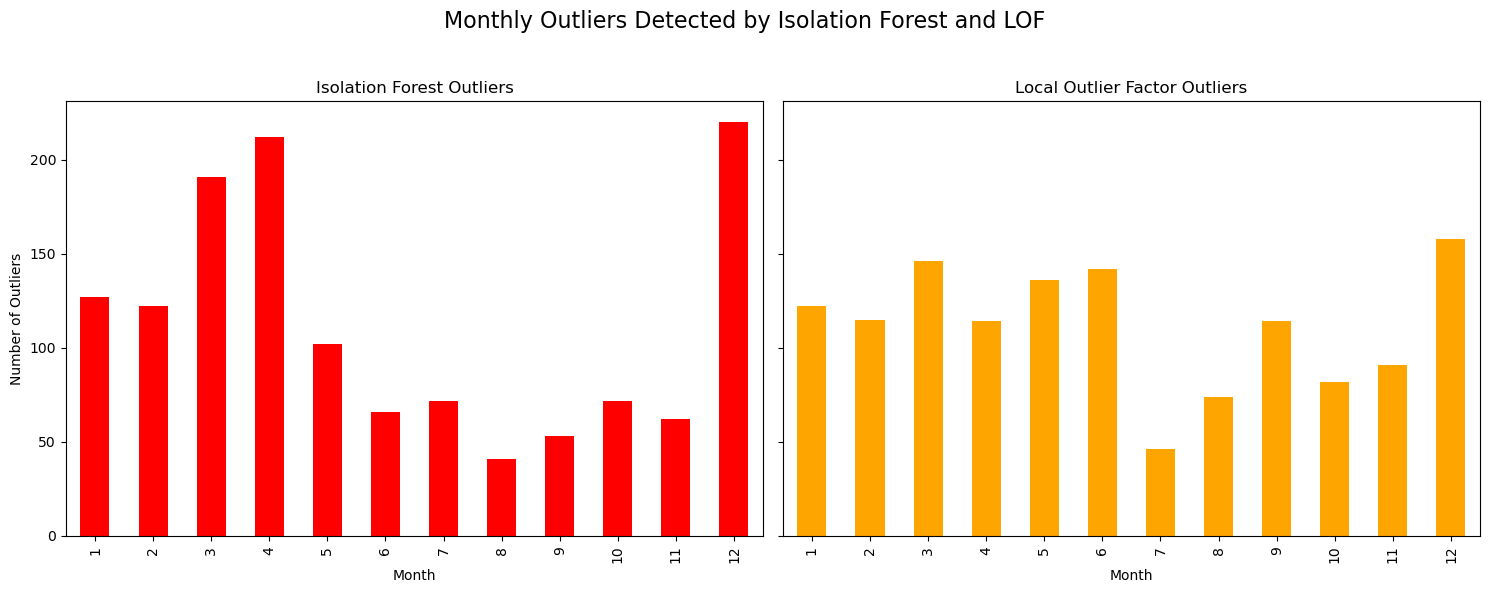

Summary of Monthly Outliers:
    Month  Isolation Forest Outliers  LOF Outliers
0       1                        127           122
1       2                        122           115
2       3                        191           146
3       4                        212           114
4       5                        102           136
5       6                         66           142
6       7                         72            46
7       8                         41            74
8       9                         53           114
9      10                         72            82
10     11                         62            91
11     12                        220           158


In [83]:
import matplotlib.pyplot as plt

# Group Isolation Forest and LOF outliers by month
iso_monthly_outliers = df_focus[df_focus['Iso_Outlier'] == 'Outlier'].groupby('month').size()
lof_monthly_outliers = df_focus[df_focus['LOF_Outlier'] == 'Outlier'].groupby('month').size()

# Create a grid for the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
fig.suptitle('Monthly Outliers Detected by Isolation Forest and LOF', fontsize=16)

# Plot Isolation Forest outliers
iso_monthly_outliers.plot(kind='bar', color='red', ax=axes[0])
axes[0].set_title('Isolation Forest Outliers')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Outliers')

# Plot LOF outliers
lof_monthly_outliers.plot(kind='bar', color='orange', ax=axes[1])
axes[1].set_title('Local Outlier Factor Outliers')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Outliers')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the title
plt.show()

# Print summary of monthly outliers
summary_table = pd.DataFrame({
    'Month': iso_monthly_outliers.index,
    'Isolation Forest Outliers': iso_monthly_outliers.values,
    'LOF Outliers': lof_monthly_outliers.values
})
print("Summary of Monthly Outliers:")
print(summary_table)


**Monthly Outliers**

**Seasonal Variations:**
1. Isolation Forest shows the **highest** number of outliers in **April (212) and December (220)**. This suggests seasonal spikes, potentially related to changes in weather or human activity (e.g., colder months or holiday seasons increasing pollution levels).
2. LOF also identifies **December (158) and March (146)** as months with a **higher** number of outliers, aligning partially with Isolation Forest.

**Consistent Months for Outliers:** 
1. Both methods detect a notable increase in December, possibly due to increased emissions during winter months or holiday-related activities (e.g., fireworks, increased vehicular traffic).
2. Months like April (Isolation Forest) and March (LOF) could represent seasonal shifts with heightened pollutant activity.

**Lowest Outliers:**
1. Isolation Forest, the months with the **lowest** outliers are **August (41) and July (72)**. These months typically experience fewer pollution events, possibly due to stable weather or reduced human activity during summer.
2. LOF, **July (46) and August (74)** also show the **least** outliers, aligning with the trend identified by Isolation Forest.

**Discrepancies Between Methods:**
1. Some months show significant differences between the two methods: For example, in **April**, Isolation Forest detects 212 outliers, while LOF detects only 114.
2. This discrepancy may arise because Isolation Forest is less sensitive to local density variations, while LOF focuses more on the local structure of the data.

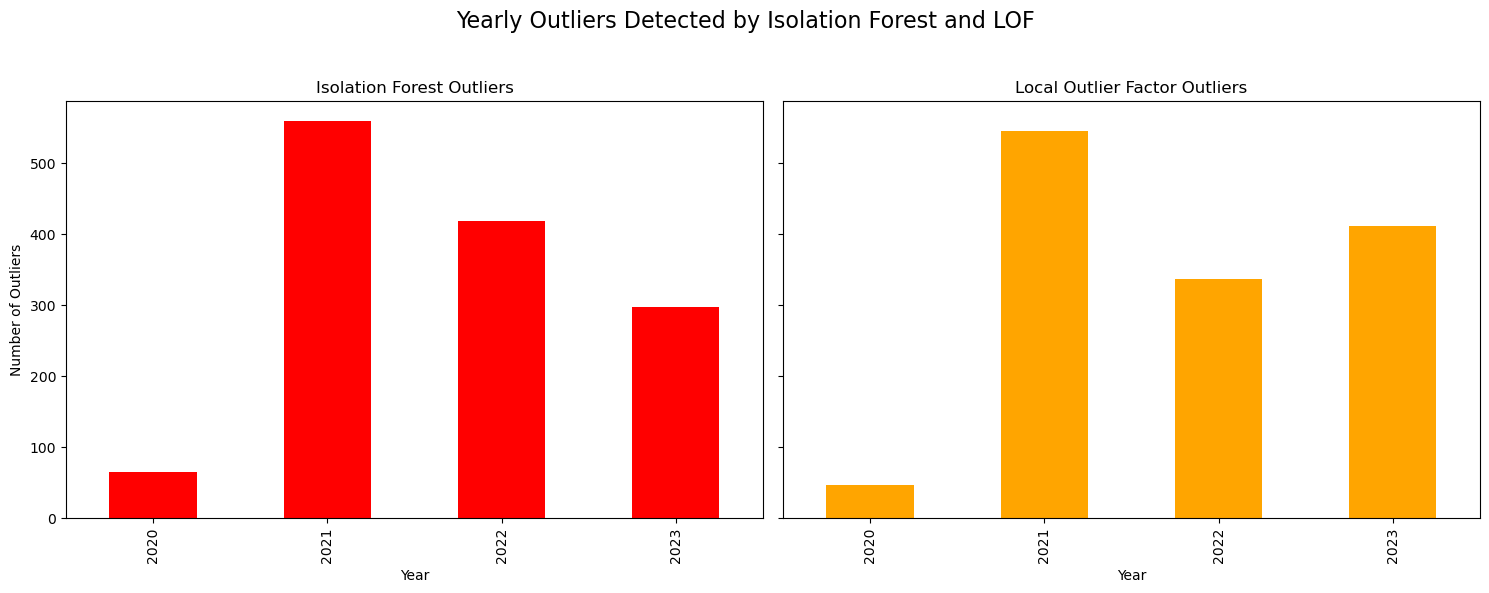

Summary of Yearly Outliers:
   Year  Isolation Forest Outliers  LOF Outliers
0  2020                         65            47
1  2021                        559           545
2  2022                        418           337
3  2023                        298           411


In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# Group Isolation Forest and LOF outliers by year
iso_yearly_outliers = df_focus[df_focus['Iso_Outlier'] == 'Outlier'].groupby('year').size()
lof_yearly_outliers = df_focus[df_focus['LOF_Outlier'] == 'Outlier'].groupby('year').size()

# Create a grid for the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
fig.suptitle('Yearly Outliers Detected by Isolation Forest and LOF', fontsize=16)

# Plot Isolation Forest outliers
iso_yearly_outliers.plot(kind='bar', color='red', ax=axes[0])
axes[0].set_title('Isolation Forest Outliers')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Outliers')

# Plot LOF outliers
lof_yearly_outliers.plot(kind='bar', color='orange', ax=axes[1])
axes[1].set_title('Local Outlier Factor Outliers')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Outliers')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the title
plt.show()

# Create a summary table
summary_table = pd.DataFrame({
    'Year': iso_yearly_outliers.index,
    'Isolation Forest Outliers': iso_yearly_outliers.values,
    'LOF Outliers': lof_yearly_outliers.values
})
print("Summary of Yearly Outliers:")
print(summary_table)


**Yearly Outliers**

**Trends Over the Years:**
1. Isolation Forest: Highest number of outliers in 2021 (559). Decline in subsequent years: 2022 (418) and 2023 (298).
2. LOF: Similarly, 2021 (545) has the most outliers, but there’s a shift in 2023 with a slight increase compared to 2022 (2023: 411 vs. 2022: 337).

**2021 as a Critical Year:**
1. Both methods agree that 2021 was a year with significant pollutant anomalies. This could indicate: Environmental conditions: Unusual weather patterns, such as temperature inversions or low wind speeds, could have trapped pollutants.
2. Human activity: Post-pandemic changes in industrial or vehicular activity might have contributed to higher pollution.

**Lower Outliers in 2020:** Both methods detect fewer outliers in 2020, likely due to global lockdowns reducing emissions from transportation and industries.

**Differing Patterns in 2023:** LOF shows an increase in outliers for 2023 (411) compared to 2022, while Isolation Forest shows a continued decline. This might suggest that LOF is capturing localized anomalies that Isolation Forest does not.

**Cross-Year and Monthly Patterns:**

**Seasonal Peaks Across Years:** Months like December consistently show high outliers across multiple years, indicating recurring seasonal patterns. Comparing seasonal trends year by year could highlight whether these peaks are increasing or decreasing.

**Alignment Between Methods:** Both methods align on broader trends, such as high outlier counts in 2021 and specific months like December.
However, LOF may highlight smaller or more localized anomalies that Isolation Forest misses.

# 4. Correlate Multivariate Outliers with Weather Conditions

**Analyze Correlation Between Pollutants and Weather Variables:**
Analyze how weather variables (e.g., temperature, humidity, wind speed) influence pollutant levels.

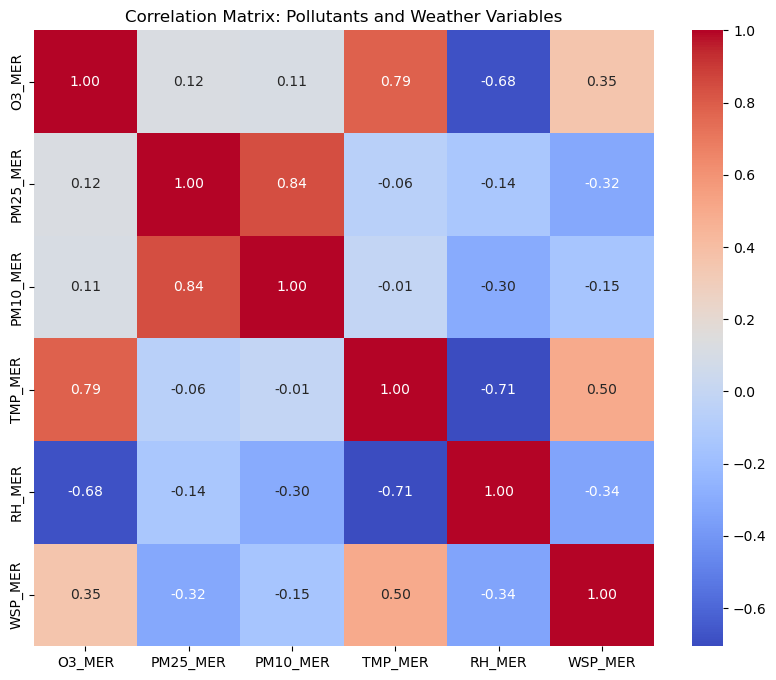

Summary of Correlation Matrix: Pollutants and Weather Variables
            O3_MER  PM25_MER  PM10_MER   TMP_MER    RH_MER   WSP_MER
O3_MER    1.000000  0.124585  0.111093  0.786092 -0.684887  0.354270
PM25_MER  0.124585  1.000000  0.844049 -0.060039 -0.138894 -0.315345
PM10_MER  0.111093  0.844049  1.000000 -0.012220 -0.299566 -0.152641
TMP_MER   0.786092 -0.060039 -0.012220  1.000000 -0.705835  0.495974
RH_MER   -0.684887 -0.138894 -0.299566 -0.705835  1.000000 -0.337953
WSP_MER   0.354270 -0.315345 -0.152641  0.495974 -0.337953  1.000000


In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of pollutants and weather variables
pollutants = ['O3_MER', 'PM25_MER', 'PM10_MER']
weather_cols = ['TMP_MER', 'RH_MER', 'WSP_MER']

# Correlation matrix for pollutants and weather variables
correlation_matrix = df_focus[pollutants + weather_cols].corr()

# Visualize correlations using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Pollutants and Weather Variables')
plt.show()

# Print the correlation matrix summary
print("Summary of Correlation Matrix: Pollutants and Weather Variables")
print(correlation_matrix)

**Key Findings**

**Relationships Among Pollutants:**
1. **PM25 and PM10** have a strong positive correlation (0.844), indicating that these pollutants often increase or decrease together. This suggests shared sources, such as traffic or industrial emissions.
2. **O3** has weak positive correlations with both PM25_MER (0.125) and PM10_MER (0.111), suggesting that ozone levels may rise independently of particulate matter.

**Insights**

**Ozone Sensitivity to Weather:** Ozone levels are highly influenced by temperature, with warmer and less humid conditions favoring its formation. This aligns with the expected behavior of ozone as a secondary pollutant.

**Particulate Matter Stability:** Particulate matter (PM25_MER and PM10_MER) appears less sensitive to temperature but is moderately affected by humidity and wind speed, highlighting its potential persistence in stagnant conditions.

**Seasonal Implications:** High temperatures during summer may exacerbate ozone pollution, while humid or rainy conditions may help mitigate particulate pollution.

# Correlate Multivariate Outliers with Weather Conditions:
Focus on weather conditions during outlier events to see if they contribute to anomalies.

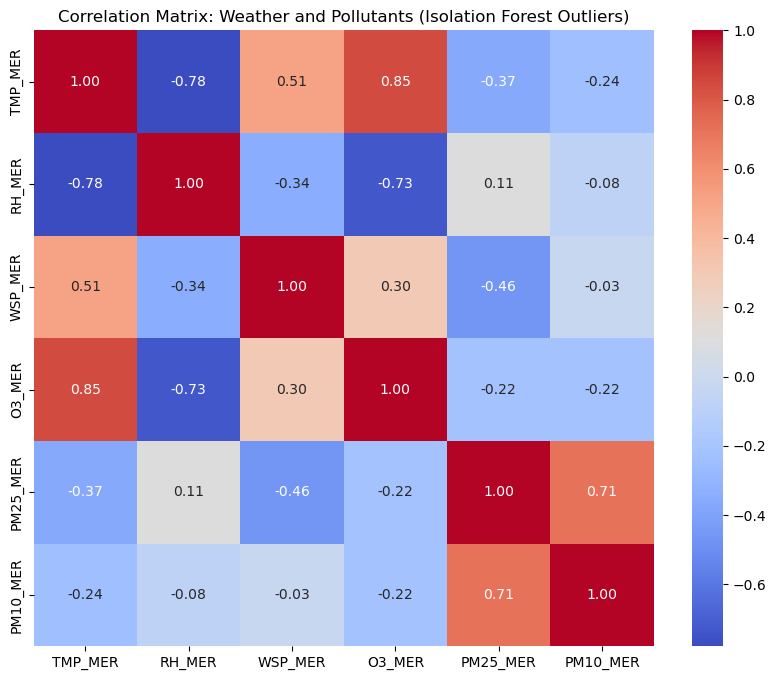

Summary of Correlation Matrix: Weather and Pollutants (Isolation Forest Outliers)
           TMP_MER    RH_MER   WSP_MER    O3_MER  PM25_MER  PM10_MER
TMP_MER   1.000000 -0.778721  0.512670  0.846308 -0.368703 -0.237619
RH_MER   -0.778721  1.000000 -0.343652 -0.731421  0.111138 -0.077339
WSP_MER   0.512670 -0.343652  1.000000  0.303305 -0.459375 -0.025492
O3_MER    0.846308 -0.731421  0.303305  1.000000 -0.220945 -0.221299
PM25_MER -0.368703  0.111138 -0.459375 -0.220945  1.000000  0.711360
PM10_MER -0.237619 -0.077339 -0.025492 -0.221299  0.711360  1.000000


In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out Isolation Forest outliers
iso_outliers = df_focus[df_focus['Iso_Outlier'] == 'Outlier']

# Correlation matrix for weather and pollutants during Isolation Forest outlier events
iso_outliers_corr = iso_outliers[weather_cols + pollutants].corr()

# Visualize correlations during outlier events
plt.figure(figsize=(10, 8))
sns.heatmap(iso_outliers_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Weather and Pollutants (Isolation Forest Outliers)')
plt.show()

# Print the correlation matrix summary
print("Summary of Correlation Matrix: Weather and Pollutants (Isolation Forest Outliers)")
print(iso_outliers_corr)

**Key Findings**

**Relationships Among Pollutants:**
1. **PM25 and PM10** maintain a strong **positive** correlation (0.711), similar to the general dataset, suggesting that they share common sources even during outlier events.
2. **O3** shows weak **negative** correlations with both PM25_MER (-0.221) and PM10_MER (-0.221), indicating that ozone behavior may differ from particulate matter during extreme conditions.

**Insights**

**Ozone Sensitivity During Outliers:**
1. Extreme ozone events are heavily influenced by high temperatures and low humidity, underscoring the role of heatwaves or dry spells in exacerbating ozone pollution.
2. Wind appears to have a moderate effect, possibly dispersing ozone over larger areas or contributing to transport from external sources.

**Particulate Matter Behavior During Outliers:** PM concentrations decrease with high temperatures and strong winds, highlighting the importance of atmospheric mixing in mitigating extreme particulate pollution.

**Weather-Driven Anomalies:** The correlations during outliers are more pronounced compared to the general dataset, emphasizing the influence of specific weather conditions on extreme pollution events.

**Comparison with General Dataset**
1. **O3:** The correlation with temperature is stronger during outliers (0.846) than in the general dataset (0.786), suggesting that **temperature** plays a more critical role in driving extreme ozone levels.
2. **PM25 and PM10:** Temperature and wind speed show stronger negative correlations during outliers compared to the general dataset, indicating that **weather conditions** are more influential during extreme particulate events.

# 5. Temporal Analysis

**Group Outliers by Month:** Analyze monthly trends for pollutants with significant outliers.

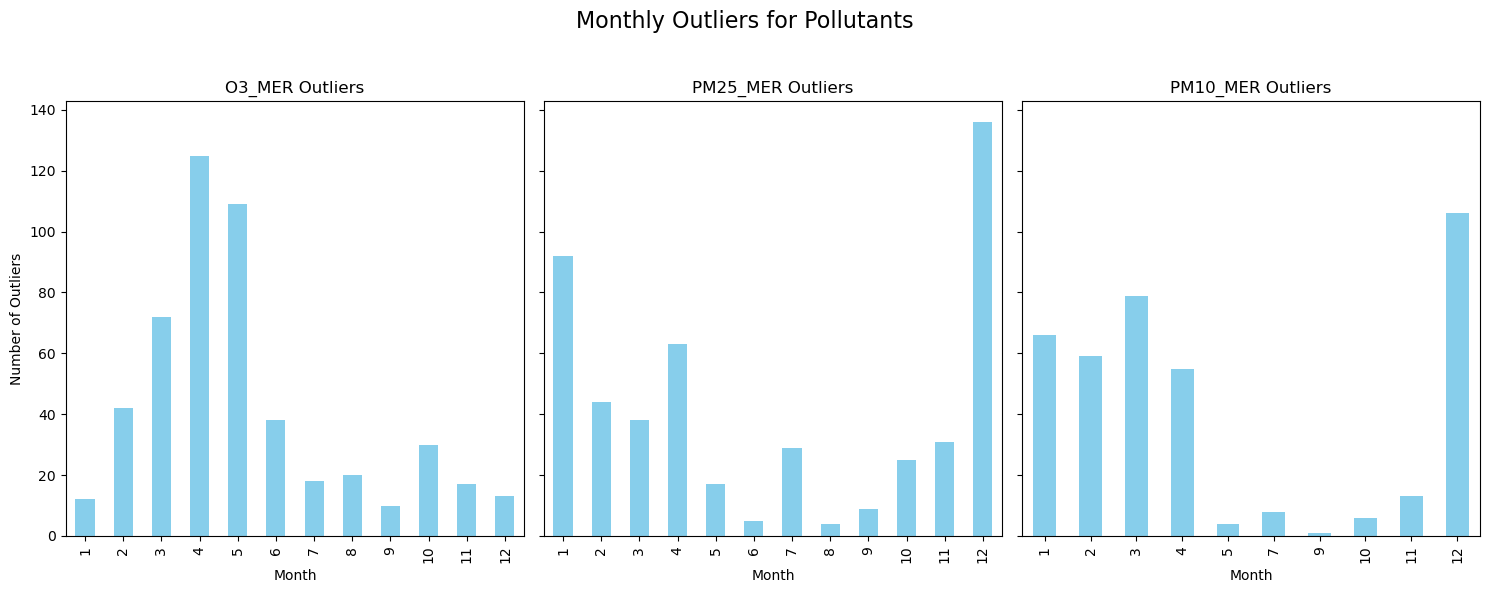

Summary of Monthly Outliers for Pollutants:
       O3_MER  PM25_MER  PM10_MER
month                            
1          12        92        66
2          42        44        59
3          72        38        79
4         125        63        55
5         109        17         4
6          38         5         0
7          18        29         8
8          20         4         0
9          10         9         1
10         30        25         6
11         17        31        13
12         13       136       106


In [127]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract month from datetime
df_focus['month'] = df_focus['datetime'].dt.month

# Initialize a DataFrame to store monthly outlier counts for all pollutants
monthly_outliers_summary = pd.DataFrame()

# Create a grid layout for bar charts
fig, axes = plt.subplots(1, len(pollutants), figsize=(15, 6), sharey=True)
fig.suptitle('Monthly Outliers for Pollutants', fontsize=16)

# Plot monthly outliers for each pollutant and store results in the summary DataFrame
for ax, pollutant in zip(axes, pollutants):
    monthly_outliers = df_focus[df_focus[f'{pollutant}_Outlier']].groupby('month').size()
    monthly_outliers_summary[pollutant] = monthly_outliers  # Store in summary DataFrame
    
    # Plot the monthly outliers for the current pollutant in the grid
    monthly_outliers.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'{pollutant} Outliers')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Outliers')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the title
plt.show()

# Print the summary of monthly outliers for all pollutants
print("Summary of Monthly Outliers for Pollutants:")
print(monthly_outliers_summary.fillna(0).astype(int))  # Replace NaN with 0 for clarity


**Insights**

**Seasonal Trends:** O3 peaks in **spring/summer,** driven by higher temperatures and increased sunlight. PM25 and PM10 peak in **winter,** likely due to heating, stagnant weather, or reduced dispersion.

**Critical Months: April (O3)** and **December (PM pollutants)** stand out as periods requiring attention due to recurring high outlier counts.

# Group Outliers by Month (Including Isolation Forest and LOF):
Analyze monthly trends for outliers identified by Isolation Forest and LOF, along with individual pollutant outliers.

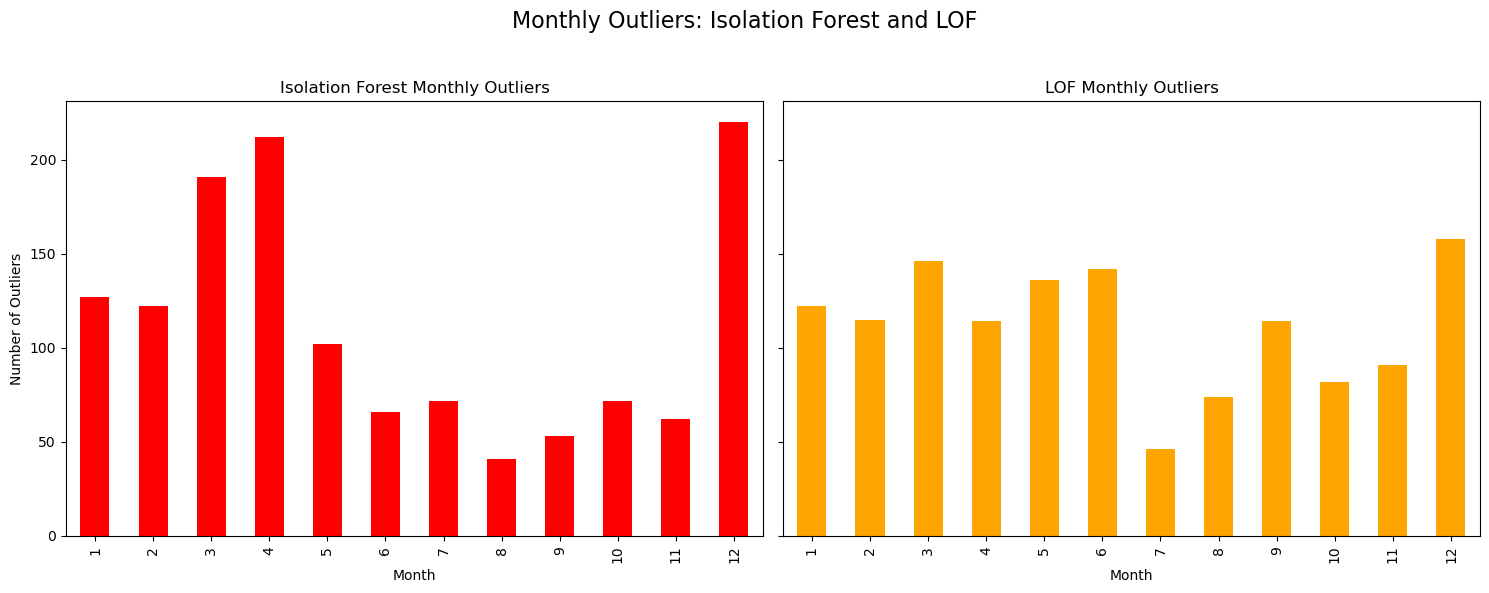

Summary of Monthly Outliers (Isolation Forest):
month
1     127
2     122
3     191
4     212
5     102
6      66
7      72
8      41
9      53
10     72
11     62
12    220
dtype: int64

Summary of Monthly Outliers (LOF):
month
1     122
2     115
3     146
4     114
5     136
6     142
7      46
8      74
9     114
10     82
11     91
12    158
dtype: int64


In [145]:
# Group Isolation Forest and LOF outliers by month
iso_monthly_outliers = df_focus[df_focus['Iso_Outlier'] == 'Outlier'].groupby('month').size()
lof_monthly_outliers = df_focus[df_focus['LOF_Outlier'] == 'Outlier'].groupby('month').size()

# Plot monthly trends for Isolation Forest and LOF
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
fig.suptitle('Monthly Outliers: Isolation Forest and LOF', fontsize=16)

# Isolation Forest monthly trends
iso_monthly_outliers.plot(kind='bar', ax=axes[0], color='red', title='Isolation Forest Monthly Outliers')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Outliers')

# LOF monthly trends
lof_monthly_outliers.plot(kind='bar', ax=axes[1], color='orange', title='LOF Monthly Outliers')
axes[1].set_xlabel('Month')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print summary
print("Summary of Monthly Outliers (Isolation Forest):")
print(iso_monthly_outliers)
print("\nSummary of Monthly Outliers (LOF):")
print(lof_monthly_outliers)


**Insights**

**Seasonal Trends:**
1. **December** emerges as a consistent month for high outliers across both methods, potentially indicating weather conditions (e.g., stagnant air) that exacerbate pollution.
2. **April and June** display discrepancies between methods, suggesting different sensitivities in detecting anomalies.

**Consistency Across Methods:** Both methods detect fewer anomalies during summer months like **July and August,** reflecting improved air quality due to favorable dispersion conditions.

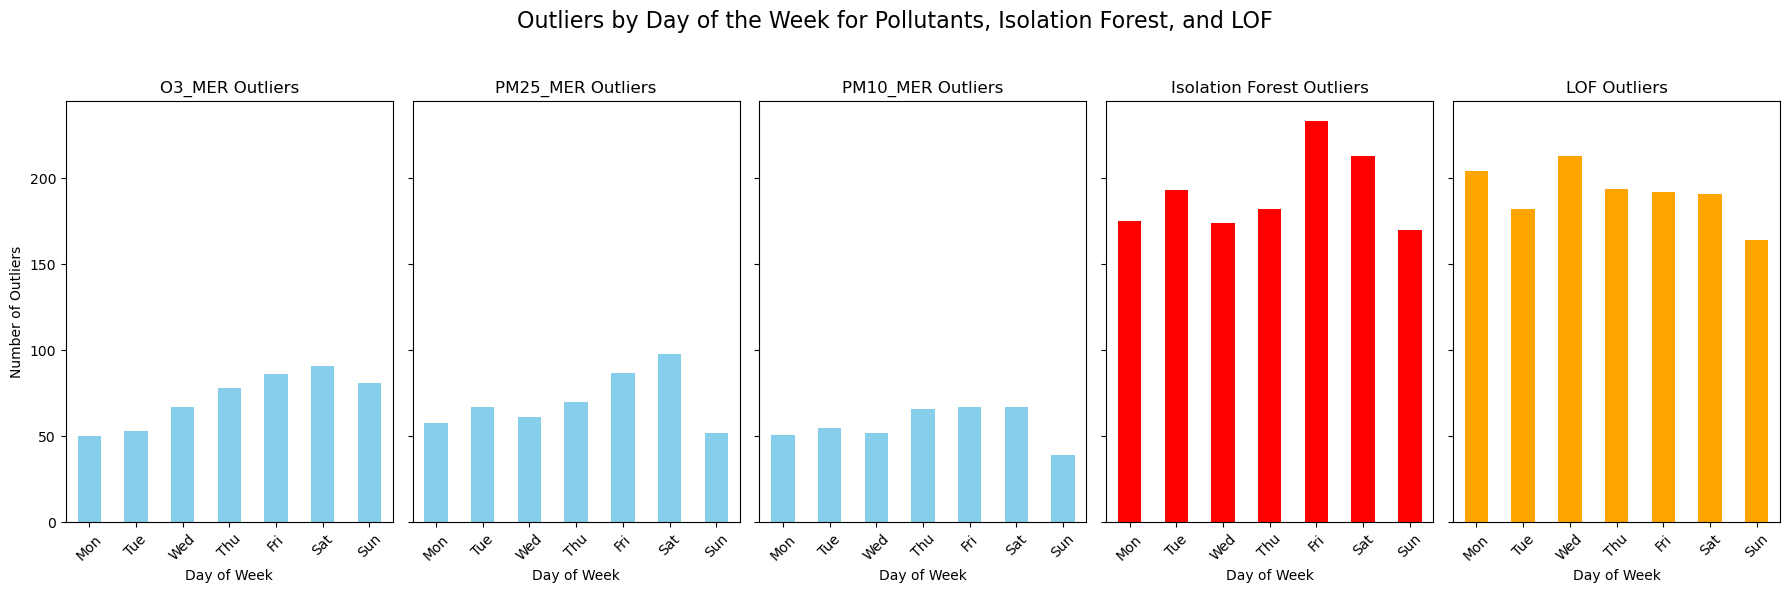

Summary of Daily Outliers for Pollutants:
             O3_MER  PM25_MER  PM10_MER
day_of_week                            
0                50        58        51
1                53        67        55
2                67        61        52
3                78        70        66
4                86        87        67
5                91        98        67
6                81        52        39

Summary of Daily Outliers for Isolation Forest and LOF:
             Isolation Forest  LOF
day_of_week                       
0                         175  204
1                         193  182
2                         174  213
3                         182  194
4                         233  192
5                         213  191
6                         170  164


In [171]:
# LOF and Isolation Forest outliers alongside individual pollutant outliers for the day of the week analysis.
import matplotlib.pyplot as plt
import pandas as pd

# Extract day of the week from datetime
df_focus['day_of_week'] = df_focus['datetime'].dt.dayofweek  # Monday = 0, Sunday = 6

# Initialize DataFrames to store outlier counts
daily_outliers_summary = pd.DataFrame()  # For pollutants
lof_isolation_summary = pd.DataFrame()  # For LOF and Isolation Forest

# Create a grid layout for bar charts
fig, axes = plt.subplots(1, len(pollutants) + 2, figsize=(18, 6), sharey=True)
fig.suptitle('Outliers by Day of the Week for Pollutants, Isolation Forest, and LOF', fontsize=16)

# Plot daily outliers for each pollutant
for i, pollutant in enumerate(pollutants):
    daily_outliers = df_focus[df_focus[f'{pollutant}_Outlier']].groupby('day_of_week').size()
    daily_outliers_summary[pollutant] = daily_outliers  # Store results in the summary DataFrame
    
    # Plot on the grid
    daily_outliers.plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'{pollutant} Outliers')
    axes[i].set_xlabel('Day of Week')
    axes[i].set_ylabel('Number of Outliers')
    axes[i].set_xticks(range(7))
    axes[i].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)

# Add Isolation Forest outliers to the grid
iso_daily_outliers = df_focus[df_focus['Iso_Outlier'] == 'Outlier'].groupby('day_of_week').size()
lof_isolation_summary['Isolation Forest'] = iso_daily_outliers  # Store results
iso_daily_outliers.plot(kind='bar', ax=axes[-2], color='red')
axes[-2].set_title('Isolation Forest Outliers')
axes[-2].set_xlabel('Day of Week')
axes[-2].set_xticks(range(7))
axes[-2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)

# Add LOF outliers to the grid
lof_daily_outliers = df_focus[df_focus['LOF_Outlier'] == 'Outlier'].groupby('day_of_week').size()
lof_isolation_summary['LOF'] = lof_daily_outliers  # Store results
lof_daily_outliers.plot(kind='bar', ax=axes[-1], color='orange')
axes[-1].set_title('LOF Outliers')
axes[-1].set_xlabel('Day of Week')
axes[-1].set_xticks(range(7))
axes[-1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the title
plt.show()

# Print the summary of daily outliers
print("Summary of Daily Outliers for Pollutants:")
print(daily_outliers_summary.fillna(0).astype(int))  # Replace NaN with 0 for clarity

print("\nSummary of Daily Outliers for Isolation Forest and LOF:")
print(lof_isolation_summary.fillna(0).astype(int))  # Replace NaN with 0 for clarity


**Insights**

**Weekend Effect:**
1. Both pollutant-specific and multivariate methods highlight elevated pollution levels on **Fridays and Saturdays**, possibly due to increased human activity.

**Agreement Between Methods:**
1. While Isolation Forest and LOF mostly align, **discrepancies** (e.g., LOF's peak on Tuesday) suggest differences in how each method captures anomalies.

# Compare Outliers to Air and Health Index:
Visualize trends in the Air and Health Index and compare with outliers.

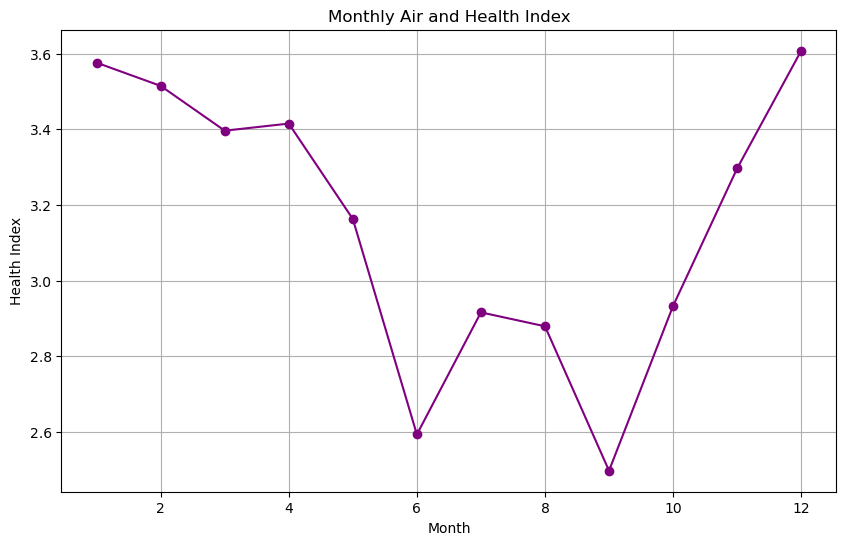

Summary of Monthly Air and Health Index:
month
1     3.575744
2     3.514403
3     3.396057
4     3.414794
5     3.162634
6     2.593056
7     2.915751
8     2.879032
9     2.497222
10    2.932796
11    3.296183
12    3.607397
Name: AirQualityIndex, dtype: float64


In [131]:
import matplotlib.pyplot as plt

# Calculate average Air and Health Index by month
monthly_health_index = df_focus.groupby('month')['AirQualityIndex'].mean()

# Plot trends in Air and Health Index
plt.figure(figsize=(10, 6))
monthly_health_index.plot(kind='line', title='Monthly Air and Health Index', color='purple', marker='o')
plt.xlabel('Month')
plt.ylabel('Health Index')
plt.grid(True)  # Add grid for better readability
plt.show()

# Print the summary of monthly average Air and Health Index
print("Summary of Monthly Air and Health Index:")
print(monthly_health_index)

**Insights**

**Health Risks in Winter:** Elevated Air and Health Index values in **winter** correspond to increased pollution levels, particularly particulate matter, posing higher health risks. This could indicate poorer air quality during winter months, likely due to **stagnant air conditions and increased emissions from heating.**

**Improved Air Quality in Summer:** Lower Air and Health Index values in **summer** coincide with reduced outliers and better meteorological conditions for pollutant dispersion, possibly due to **improved dispersion and lower emissions.**

# 6. Connect Pollutants to Health Impacts

**Correlate Pollutants with Air and Health Index:** Analyze correlations between pollutants and health impacts.

In [134]:
for pollutant in pollutants:
    correlation = df_focus[pollutant].corr(df_focus['AirQualityIndex'])
    print(f"Correlation between {pollutant} and Air and Health Index: {correlation:.2f}")


Correlation between O3_MER and Air and Health Index: 0.32
Correlation between PM25_MER and Air and Health Index: 0.32
Correlation between PM10_MER and Air and Health Index: 0.35


**Key Findings and Insights**

**Positive Correlation:** All three pollutants **(O3, PM2.5, PM10)** show a positive correlation with the Air and Health Index, indicating that higher levels of these pollutants are associated with higher health risks.

**Strength of Correlations:**
1. **PM10** exhibits the strongest correlation (0.35) with the Air and Health Index, suggesting that it may have a more significant **impact on health** outcomes compared to O3 and PM2.5.
2. **O3 and PM25** both show a correlation of 0.32, indicating a similar level of influence on health.
   
**Implications for Public Health:** These findings highlight the need for **monitoring and managing air quality**, particularly concerning PM10 levels, to mitigate health risks associated with air pollution.

In [175]:
# Health Index During Outlier Events: Assess how outlier events affect Air and Health Index
for pollutant in pollutants:
    avg_health_index_outliers = df_focus.loc[df_focus[f'{pollutant}_Outlier'], 'AirQualityIndex'].mean()
    print(f"Average Health Index during {pollutant} outliers: {avg_health_index_outliers:.2f}")


Average Health Index during O3_MER outliers: 4.44
Average Health Index during PM25_MER outliers: 4.09
Average Health Index during PM10_MER outliers: 4.07


**Comparative Analysis:**
1. The highest average Health Index is observed during **O3** outliers, which could imply a stronger **effect on health** when ozone levels spike compared to PM2.5 and PM10.
2. **PM2.5 and PM10** have similar average Health Index values during their outliers, indicating comparable health impacts from these pollutants.

**Public Health Considerations:**
1. The elevated average Health Index values during outliers for all three pollutants underscore the importance of effective air quality management and health risk mitigation strategies.
2. The findings suggest a need for **targeted public health interventions** during periods of high pollutant levels to protect vulnerable populations.

In [150]:
# Average Health Index during Isolation Forest outlier events
avg_aqi_iso_outliers = df_focus.loc[df_focus['Iso_Outlier'] == 'Outlier', 'AirQualityIndex'].mean()
print(f"Average Health Index During Isolation Forest Outliers: {avg_aqi_iso_outliers:.2f}")

# Average Health Index during LOF outlier events
avg_aqi_lof_outliers = df_focus.loc[df_focus['LOF_Outlier'] == 'Outlier', 'AirQualityIndex'].mean()
print(f"Average Health Index During LOF Outliers: {avg_aqi_lof_outliers:.2f}")


Average Health Index During Isolation Forest Outliers: 3.98
Average Health Index During LOF Outliers: 3.45


**Comparative Analysis:** Isolation Forest identifies outliers with a higher associated Health Index compared to LOF, suggesting it may be detecting events with a greater health significance.

**Public Health Considerations:** Both methods highlight periods of elevated **health risks**, reinforcing the importance of monitoring anomalies in air quality data to mitigate potential health impacts.

In [141]:
# Compare results of Isolation Forest and LOF
comparison = df_focus[['Iso_Outlier', 'LOF_Outlier']]
agreement = (comparison['Iso_Outlier'] == comparison['LOF_Outlier']).value_counts()

print("Agreement Between Isolation Forest and LOF:")
print(agreement)


Agreement Between Isolation Forest and LOF:
True     24794
False     1994
Name: count, dtype: int64


**Comparative Analysis:**
1. The high agreement rate suggests **consistency** between Isolation Forest and LOF in identifying outliers.
2. The disagreements highlight potential differences in **sensitivity or detection criteria**, warranting further evaluation of both methods.

**Public Health Considerations:** Consistent outlier detection supports reliable identification of health-relevant anomalies, essential for proactive interventions. Discrepancies should be analyzed to ensure no critical outliers are missed.

# Overall Findings and Recommendations

**Significant Pollutants with Outliers:**
1. **O3 (Ozone):** Consistently identified as a significant outlier by all methods, correlating with notable increases in the Air and Health Index, aligning with its high oxidation capacity and respiratory impacts outlined by Molina (2023) and Edomex (2018).
2. **PM2.5 and PM10:** These particulate matter pollutants were frequently flagged as outliers, aligning with their known health risks, such as aggravated asthma and cardiovascular issues, as detailed in the literature (Molina, 2023).

**Influence of Weather Conditions:**
1. Seasonal patterns, such as higher **O3 concentrations from March to May**, were observed due to elevated temperatures and intense solar radiation, consistent with findings by Mexico Business News (2024).
2. Increased **PM** levels were detected during the dry season **(November to May)**, often exacerbated by reduced rainfall and biomass burning during holidays, as highlighted in Edomex (2018).
   
**Recurring Seasonal Trends and Anomalies:**
1. Spikes in pollutant levels were particularly notable in **December**, driven by firework activity and bonfires during Christmas and New Year, corroborating seasonal trends noted in Molina (2023).
2. Specific anomalies in **2021** were linked to **urban activity changes** during the COVID-19 pandemic, echoing broader global patterns seen in air quality studies.

**Recommendations**

**Policy and Intervention:**
1. Implement **targeted pollution control** measures during months with recurring spikes, such as stricter firework regulations in December, supported by the need for seasonally adaptive policies noted in Edomex (2018).
2. Enhance public awareness campaigns about reducing biomass burning and its health implications, aligning with recommendations for community involvement in ProAire strategies.
   
**Focus on Key Pollutants:**
1. **Prioritize mitigation strategies** for O3, PM2.5, and PM10, as these pollutants have significant health impacts and were consistently flagged as outliers, aligning with their prioritization in government policies (Government of Mexico City, 2024).
2. **Utilize Isolation Forest** for anomaly detection in predictive models to proactively manage high-risk periods, ensuring alignment with health-focused data monitoring systems like SIMAT. It's important to note that this model was the **most reliable method** in detecting anomalies with higher Health Index values compared to Local Outlier Factor (LOF), emphasizing its suitability for health-focused anomaly detection.
